In [184]:
import numpy as np 
import pandas as pd 
from datetime import timedelta
import matplotlib.pyplot as plt
from scipy.signal import deconvolve
import holidays
from analysis import *

In [185]:
data = pd.read_csv("../Data/daneOkresoweKSE.csv", sep=';', skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)

Electric.loc[Electric.Hour == 24, 'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0

Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + Electric['Hour'].astype(str) + ':' + Electric.Minute.astype(str) + ':00')
Electric['Seconds'] = (Electric.Date - Electric.Date[0]).dt.total_seconds()
Electric = Electric[['Date', 'Seconds', 'Load']]
Electric['Day'] = Electric['Date'].dt.day_name()
Electric['Minutes'] = Electric['Date'].dt.minute
Electric['Hour'] = Electric['Date'].dt.hour

poland_holidays = holidays.CountryHoliday('Poland')
Electric['Holiday'] = Electric.Date.apply(lambda x: x in poland_holidays)
Electric.loc[Electric.Day.isin(['Sunday']) ,'Holiday'] = True

In [186]:
import emd
from scipy import ndimage

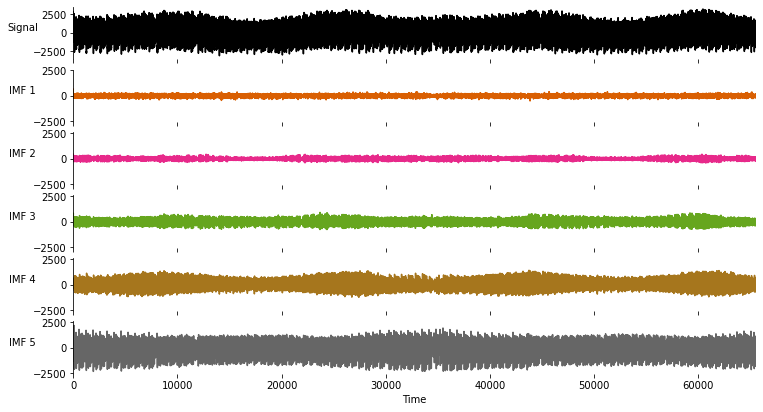

In [215]:
# Run a mask sift
imf = emd.sift.mask_sift(Electric.Load.to_numpy(), max_imfs=5) #, nprocesses=6)

# Visualise the IMFs
sample_rate = 256*64
fig = plt.figure(figsize=(12, 6))
emd.plotting.plot_imfs(imf[:sample_rate*4, :], cmap=True, scale_y=True, fig=fig)

In [216]:
# Extract frequency information
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')

# Extract cycle locations
all_cycles = emd.cycles.get_cycle_vector(IP, return_good=False)
good_cycles = emd.cycles.get_cycle_vector(IP, return_good=True)

In [217]:
thresh = np.percentile(IA[:, 2], 33)
mask = IA[:, 2] > thresh

mask_cycles = emd.cycles.get_cycle_vector(IP, return_good=True, mask=mask)

In [218]:
cycle_amp = emd.cycles.get_cycle_stat(all_cycles[:, 2], IA[:, 2], out='samples', func=np.max)

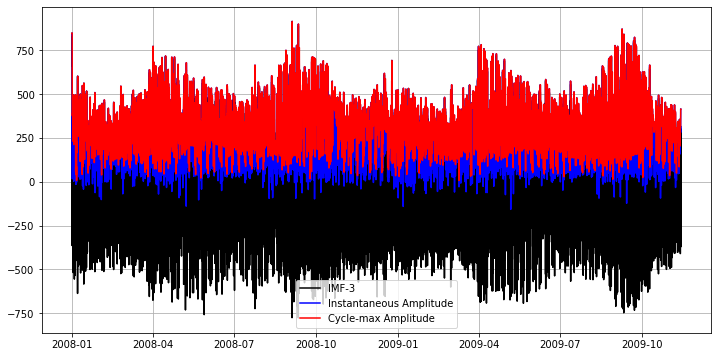

In [219]:
t = Electric.Date.to_numpy()
# Make a summary figure
plt.figure(figsize=(12, 6))
plt.plot(t[:sample_rate*4], imf[:sample_rate*4, 2], 'k')
plt.plot(t[:sample_rate*4], IA[:sample_rate*4, 2], 'b')
plt.plot(t[:sample_rate*4], cycle_amp[:sample_rate*4], 'r')
plt.grid()
plt.legend(['IMF-3', 'Instantaneous Amplitude', 'Cycle-max Amplitude'])

In [220]:
cycle_freq = emd.cycles.get_cycle_stat(all_cycles[:, 2], IF[:, 2],
                                       out='samples', func=np.mean)

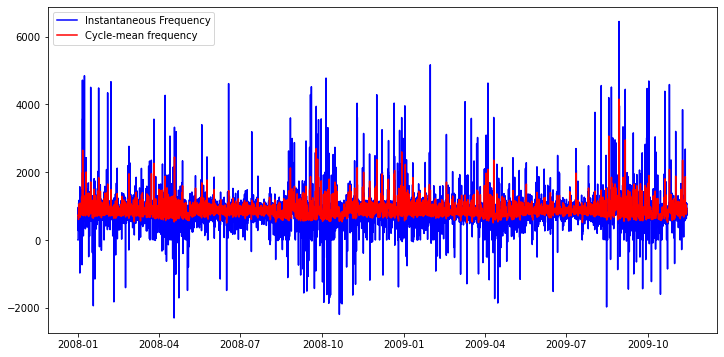

In [221]:
# Make a summary figure
plt.figure(figsize=(12, 6))
plt.plot(t[:sample_rate*4], IF[:sample_rate*4, 2], 'b')
plt.plot(t[:sample_rate*4], cycle_freq[:sample_rate*4], 'r')
plt.legend(['Instantaneous Frequency', 'Cycle-mean frequency'])

<ipython-input-225-c4d26ef838ee>:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(t[:sample_rate*4], f, shht[:, :sample_rate*4], cmap='hot_r', vmin=0, shading='nearest')


Text(0, 0.5, 'Frequency (Hz)')

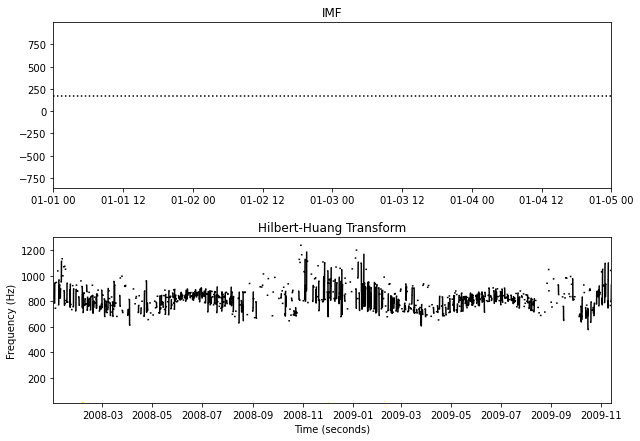

In [225]:
# Compute cycle freq using amplitude masked-cycle indices
cycle_freq = emd.cycles.get_cycle_stat(mask_cycles[:, 2], IF[:, 2], out='samples', func=np.mean)

# Carrier frequency histogram definition
freq_range = (3, 25, 64)

# Compute the 2d Hilbert-Huang transform (power over time x carrier frequency)
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, mode='amplitude', sum_time=False)

# Add a little smoothing to help visualisation
shht = ndimage.gaussian_filter(hht, 1)

# Make a summary plot
plt.figure(figsize=(10, 7))
plt.subplots_adjust(hspace=.3)
plt.subplot(211)
plt.plot(t[:sample_rate*4], imf[:sample_rate*4, 2], 'k')
plt.plot((0, 4), (thresh, thresh), 'k:')
plt.xlim(0, 4)
plt.title('IMF')
plt.subplot(212)
plt.pcolormesh(t[:sample_rate*4], f, shht[:, :sample_rate*4], cmap='hot_r', vmin=0, shading='nearest')
plt.plot(t[:sample_rate*4], cycle_freq[:sample_rate*4], 'k')
plt.title('Hilbert-Huang Transform')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')

In [ ]:
# Compute cycle average frequency for all cycles and masked cycles
all_cycle_freq = emd.cycles.get_cycle_stat(all_cycles[:, 2], IF[:, 2], func=np.mean)
mask_cycle_freq = emd.cycles.get_cycle_stat(mask_cycles[:, 2], IF[:, 2], func=np.mean)

# Compute cycle frequency range for all cycles and for masked cycles
all_cycle_amp = emd.cycles.get_cycle_stat(all_cycles[:, 2], IA[:, 2], func=np.mean)
mask_cycle_amp = emd.cycles.get_cycle_stat(mask_cycles[:, 2], IA[:, 2], func=np.mean)

In [249]:
x_up = np.mean([max(mask_cycle_freq), max(all_cycle_freq)])
x_down = min(min(mask_cycle_freq), min(all_cycle_freq))

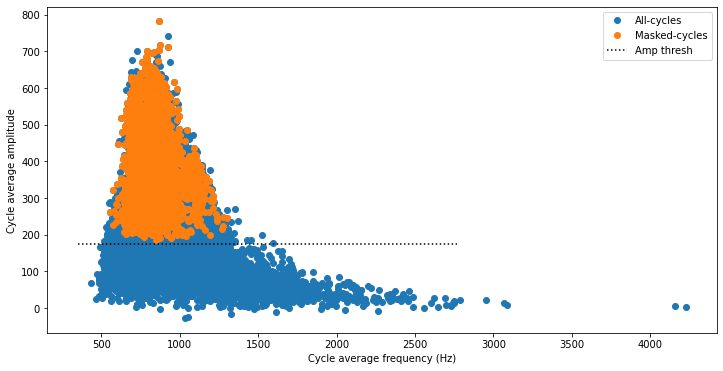

In [252]:
# Make a summary figures
plt.figure(figsize=(12, 6))
plt.plot(all_cycle_freq, all_cycle_amp, 'o')
plt.plot(mask_cycle_freq, mask_cycle_amp, 'o')
plt.xlabel('Cycle average frequency (Hz)')
plt.ylabel('Cycle average amplitude')
# x_down * (1 - 0.2)
plt.plot((x_down * 0.8, x_up), (thresh, thresh), 'k:')
plt.legend(['All-cycles', 'Masked-cycles', 'Amp thresh'])

In [253]:
# Compute cycle average frequency for all cycles and masked cycles
all_cycle_freq = emd.cycles.get_cycle_stat(all_cycles[:, 2], IF[:, 2], func=np.mean)
mask_cycle_freq = emd.cycles.get_cycle_stat(mask_cycles[:, 2], IF[:, 2], func=np.mean)

In [254]:
# Define a simple function to compute the range of a set of values
def degree_nonlinearity(x):
    return np.std((x - x.mean()) / x.mean())


# Compute cycle freuquency range for all cycles and for masked cycles
all_cycle_freq_don = emd.cycles.get_cycle_stat(all_cycles[:, 2], IF[:, 2],
                                               func=degree_nonlinearity)
cycle_freq_don = emd.cycles.get_cycle_stat(mask_cycles[:, 2], IF[:, 2],
                                           func=degree_nonlinearity)

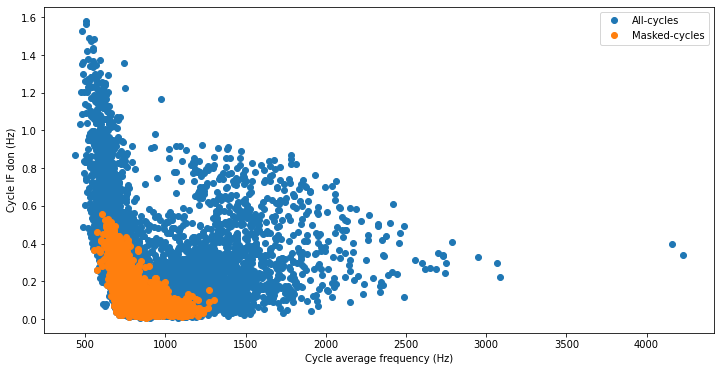

In [256]:
# Make a summary figures
plt.figure(figsize=(12, 6))
plt.plot(all_cycle_freq, all_cycle_freq_don, 'o')
plt.plot(mask_cycle_freq, cycle_freq_don, 'o')
plt.xlabel('Cycle average frequency (Hz)')
plt.ylabel('Cycle IF don (Hz)')
plt.legend(['All-cycles', 'Masked-cycles'])

In [116]:
#Electric.loc[Electric.Day == 'Saturday', 'Holiday'] = True

Electric

,Date,Seconds,Load,Day,Minutes,Hour,Holiday
0,2008-01-01 00:15:00,0.0,15938.8,Tuesday,15,0,True
1,2008-01-01 00:30:00,900.0,15770.4,Tuesday,30,0,True
2,2008-01-01 00:45:00,1800.0,15766.3,Tuesday,45,0,True
3,2008-01-01 01:00:00,2700.0,15415.2,Tuesday,0,1,True
4,2008-01-01 01:15:00,3600.0,15351.8,Tuesday,15,1,True
...,...,...,...,...,...,...,...
315643,2016-12-31 23:00:00,284078700.0,15952.7,Saturday,0,23,False
315644,2016-12-31 23:15:00,284079600.0,15865.3,Saturday,15,23,False
315645,2016-12-31 23:30:00,284080500.0,15693.5,Saturday,30,23,False
315646,2016-12-31 23:45:00,284081400.0,15508.3,Saturday,45,23,False


No handles with labels found to put in legend.


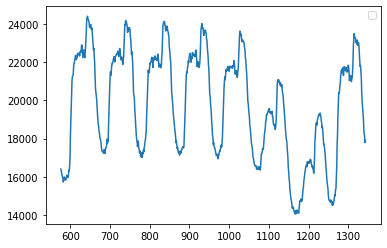

In [117]:
# Sottrarre solo la parte angolare del fit lineare ha come effetto di
# scorrelare (non completamente) le 3 distribuzioni visibili nel'istogramma
# per la deconvoluzione  

m, q = np.polyfit(x=Electric.index, y=Electric.Load, deg=1)
load_lin = m * Electric.index

Electric['Load_detrend'] = Electric.Load - load_lin

#plt.plot(Electric.Load - load_lin, label='load detrended')
#plt.plot(load_lin - q, label='lin (without q)')
plt.legend()

plt.plot(Electric.Load[96*7-96:96*14])


In [5]:
cutting_day = '2014-12-30'
train_set = Electric[Electric.Date <= pd.to_datetime(cutting_day, format='%Y-%m-%d')]
test_set = Electric[Electric.Date >= pd.to_datetime(cutting_day, format='%Y-%m-%d')]

In [118]:
def psf_forecasting(df, feature, wavelet='sym4', thr=0.04):
    
    if feature == 'load_denoised':    
        df[feature] = wavelet_filter(df['Load_detrend'].to_numpy(), 
                                     wavelet=wavelet,
                                     threshold=thr)
    else:
        pass

    f = {feature: ['mean', 'std']}
    psfs = df.groupby(['Hour',
                       'Minutes']).agg(f).reset_index()[feature].to_numpy()

    psf = psfs[:, 0]
    psf_up = psf + 1.96 * psfs[:, 1]
    psf_low = psf - 1.96 * psfs[:, 1]

    load = df[feature].to_numpy()
    deconv_psf = deconvolution(load, psf)
    deconv_psfup = deconvolution(load, psf_up)
    deconv_psflow = deconvolution(load, psf_low)

    load_psf = np.convolve(deconv_psf, psf, 'valid')[:-96]
    load_up = np.convolve(deconv_psfup, psf_up, 'valid')[:-96]
    load_low = np.convolve(deconv_psflow, psf_low, 'valid')[:-96]
    
    #plt.plot(psf)
    plt.plot(deconv_psf[:96*14])
    return deconv_psf, psf

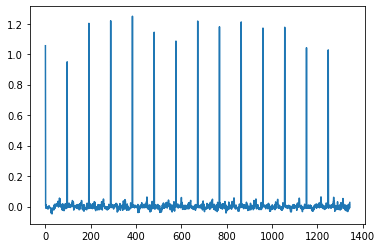

In [119]:
deconv, psf = psf_forecasting(Electric, 'Load_detrend')

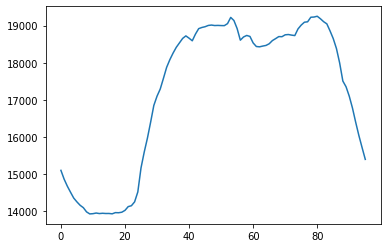

In [121]:
plt.plot(psf)

In [120]:
deconv[deconv < 0.2] = 0

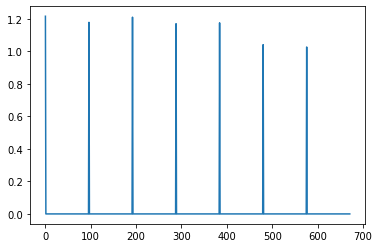

In [122]:
plt.plot(deconv[96*7:96*14])
#plt.plot(Electric.Date[:96*14], Electric.Load[:96*14])

In [124]:
Electric['deconv'] = deconv

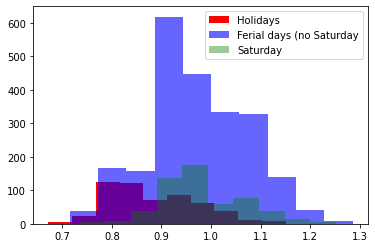

In [134]:
mask1 = Electric.deconv > 0
mask2 = Electric.Day != 'Saturday' 
plt.hist(Electric[(Electric.Holiday == True) & mask1].deconv, color='r', label='Holidays')
plt.hist(Electric[(Electric.Holiday == False) & mask1 & mask2].deconv, color='b',
         alpha=0.6, label='Ferial days (no Saturday')
plt.hist(Electric[(Electric.Holiday == False) & (Electric.Day == 'Saturday') & mask1].deconv, color='g'
         , alpha=0.4, label='Saturday')
plt.legend()

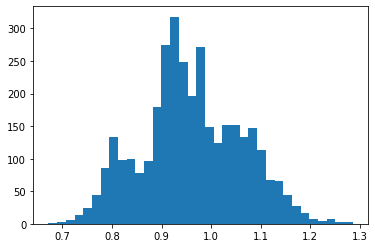

In [135]:
plt.hist(deconv[deconv > 0], bins='auto');

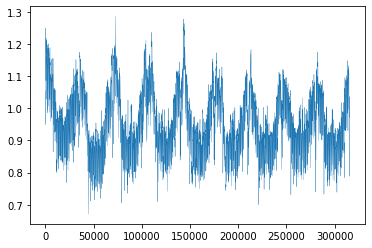

In [154]:
plt.plot(Electric.loc[mask1, 'deconv'], lw=0.3)

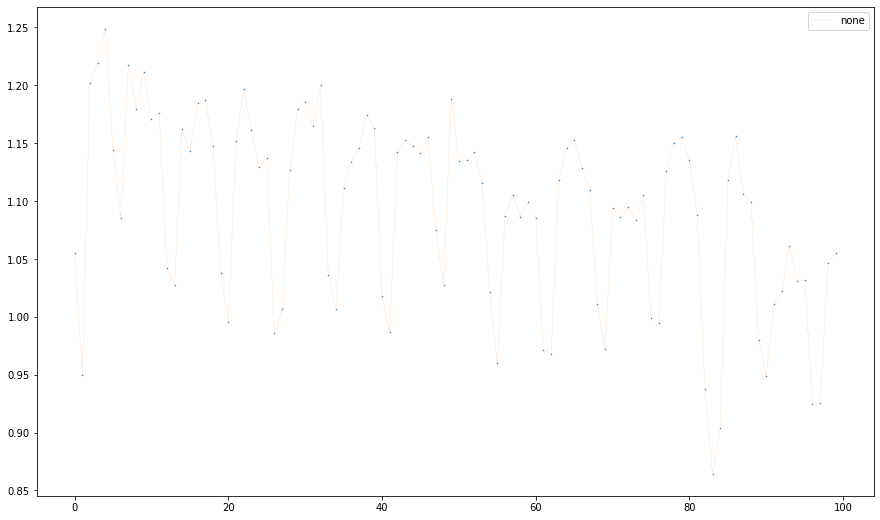

In [178]:
from scipy.interpolate import CubicSpline

y = Electric[mask1].deconv.to_numpy()[:100]
n = len(y)

cs = CubicSpline(x=range(n), y=y)
xs = np.arange(0, n)

plt.figure(figsize=(15, 9))
plt.plot(range(n), y, '.', markersize=1)
plt.plot(cs(xs, extrapolate='periodic'), lw=0.1, label='none')
#plt.plot(cs(xs, 1), lw=0.1, label='coeff=1')
#plt.plot(cs(xs, 2), lw=0.1, label='coeff=2')
plt.legend()

In [183]:
from statsmodels.tsa.seasonal import seasonal_decompose

df = Electric.copy()
df.set_index('Date')
df
#ts_dicomposition = seasonal_decompose(x=Electric.Load, model='additive')
#trend_estimate = ts_dicomposition.trend
#seasonal_estimate = ts_dicomposition.seasonal
#residual_estimate = ts_dicomposition.resid

,Date,Seconds,Load,Day,Minutes,Hour,Holiday,Load_detrend,deconv
0,2008-01-01 00:15:00,0.0,15938.8,Tuesday,15,0,True,15938.800000,1.055256
1,2008-01-01 00:30:00,900.0,15770.4,Tuesday,30,0,True,15770.395045,0.000000
2,2008-01-01 00:45:00,1800.0,15766.3,Tuesday,45,0,True,15766.290090,0.000000
3,2008-01-01 01:00:00,2700.0,15415.2,Tuesday,0,1,True,15415.185135,0.000000
4,2008-01-01 01:15:00,3600.0,15351.8,Tuesday,15,1,True,15351.780179,0.000000
...,...,...,...,...,...,...,...,...,...
315643,2016-12-31 23:00:00,284078700.0,15952.7,Saturday,0,23,False,14388.645832,0.971670
315644,2016-12-31 23:15:00,284079600.0,15865.3,Saturday,15,23,False,14301.240877,0.971670
315645,2016-12-31 23:30:00,284080500.0,15693.5,Saturday,30,23,False,14129.435922,0.971670
315646,2016-12-31 23:45:00,284081400.0,15508.3,Saturday,45,23,False,13944.230967,0.971670
